In [199]:
import pandas as pd
import os.path as op
import numpy as np
from tms_risk.utils import get_all_behavior, get_subjects
from tqdm.contrib.itertools import product
import matplotlib.pyplot as plt
import pingouin
import pkg_resources
import yaml

In [200]:
def get_pdf(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    if n_voxels == 1:
        key = 'decoded_pdfs.volume.cv_voxel_selection'
    else:
        key = 'decoded_pdfs.volume'

    subject = f'{subject:02d}'

    if denoise:
        key += '.denoise'

    if smoothed:
        key += '.smoothed'

    if pca_confounds and not denoise:
        key += '.pca_confounds'

    if natural_space:
        key += '.natural_space'

    if n_voxels == 1:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_space-T1w_pars.tsv')
    else:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_nvoxels-{n_voxels}_space-T1w_pars.tsv')

    if op.exists(pdf):
        pdf = pd.read_csv(pdf, sep='\t', index_col=[0,1])
        pdf.columns = pdf.columns.astype(float)

        if natural_space:
            pdf = pdf.loc[:, 5:112]
        else:
            pdf = pdf.loc[:, np.log(5):np.log(112)]
    else:
        print(pdf)
        pdf = pd.DataFrame(np.zeros((0, 0)))
    
    pdf /= np.trapz(pdf, pdf.columns, axis=1)[:, np.newaxis]

    return pdf

def get_decoding_info(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    pdf = get_pdf(subject, session, pca_confounds=pca_confounds, denoise=denoise, smoothed=smoothed, bids_folder=bids_folder, mask=mask, n_voxels=n_voxels, natural_space=natural_space)

    E = pd.Series(np.trapz(pdf*pdf.columns.values[np.newaxis,:], pdf.columns, axis=1), index=pdf.index)

    E = pd.concat((E,), keys=[(int(subject), int(session), 'pca_confounds' if pca_confounds else 'no pca', 'GLMstim' if denoise else "glm", 'smoothed' if smoothed else 'not smoothed', mask, n_voxels,
                                'natural' if natural_space else 'log')],
    names=['subject', 'session', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'space']).to_frame('E')

    
    E['sd'] = np.trapz(np.abs(E.values - pdf.columns.astype(float).values[np.newaxis, :]) * pdf, pdf.columns, axis=1)

    return E

In [201]:
subjects = [int(sub.subject) for sub in get_subjects(all_tms_conditions=False, exclude_outliers=True)]
sessions = [1]
pca_confounds = [False]
denoise = [True]
smoothed = [False]
masks = ['NPCr', 'NPC12r']
n_voxels = [1, 100]
natural_space = [False]


pred = []
pdfs = []
for (sub, session, pcac, den, smooth, mask, nv, ns) in product(subjects, sessions, pca_confounds, denoise, smoothed, masks, n_voxels, natural_space):

    if not ((session == 1) & (nv == 0)):
        pred.append(get_decoding_info(sub, session, pcac, den, smooth, '/data/ds-tmsrisk', mask, nv, ns))

pred = pd.concat(pred)


df = get_all_behavior(drop_no_responses=False)
pred = pred.join(df, how='inner')

r2_ = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run']).apply(lambda d: pingouin.corr(d['E'], d['log(n1)']))
r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()

  0%|          | 0/292 [00:00<?, ?it/s]

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')
/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:56: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return pd.concat(behavior)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_20977/1217705090.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()


In [202]:
import arviz as az
idata = az.from_netcdf('/data/ds-tmsrisk/derivatives/cogmodels/model-everyone_trace.netcdf')

In [203]:
n1_evidence_sd = idata.posterior['n1_evidence_sd'].to_dataframe()
n2_evidence_sd = idata.posterior['n2_evidence_sd'].to_dataframe()

In [204]:
import seaborn as sns
import arviz as az

def get_ci(x):
    return az.hdi(x.values.ravel())

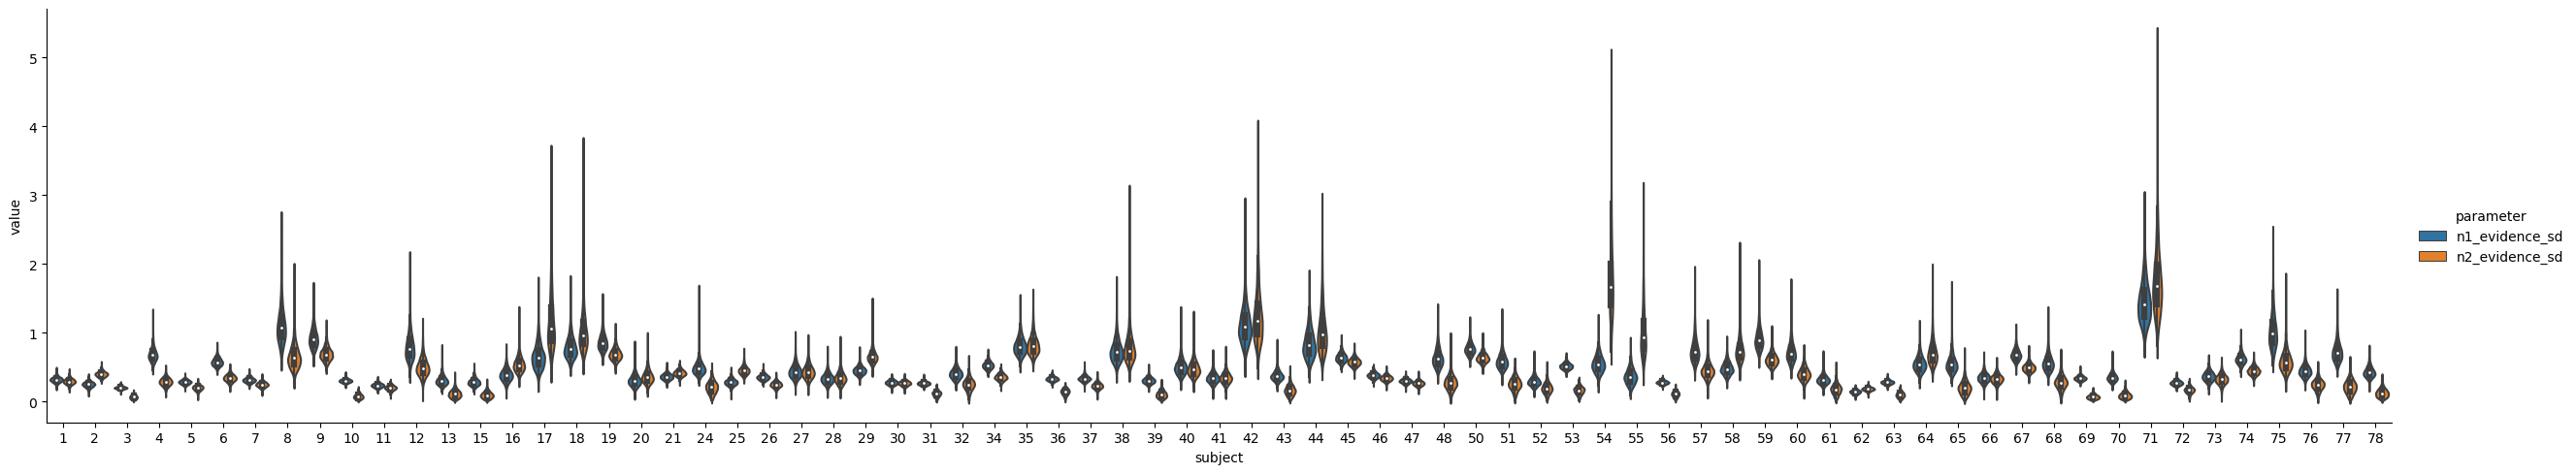

In [205]:
evidence_sd = pd.concat((n1_evidence_sd, n2_evidence_sd), axis=1)
evidence_sd.columns.name = 'parameter'
evidence_sd = evidence_sd.stack().to_frame('value')

# Make sure that the markers do not get connected
sns.catplot(x='subject', y='value', hue='parameter', data=evidence_sd.reset_index(), kind='violin', errorbar=get_ci, aspect=5, )

In [206]:
mean_evidence_sd = evidence_sd.groupby(['subject', 'parameter']).mean()
pingouin.corr(*mean_evidence_sd.unstack('parameter').values.T)

,n,r,CI95%,p-val,BF10,power
pearson,73,0.677096,"[0.53, 0.78]",4.800553e-11,2.327e+08,1.0


In [207]:
def plot_scatter_with_errors(data, xlabel='Vertex', ylabel='IPS', **kwargs):

    x = data[('mean', xlabel)]
    y = data[('mean', ylabel)] 

    xerr_min = x - data['ci_min', xlabel]
    xerr_max = data['ci_max', xlabel] - x

    yerr_min = y - data['ci_min', ylabel]
    yerr_max = data['ci_max', ylabel] - y


    plt.errorbar(x, y, [yerr_min, yerr_max], [xerr_min, xerr_max], fmt='.', markersize=0, alpha=0.5, **kwargs)
    plt.scatter(data[('mean', xlabel)], data[('mean', ylabel)], marker='.', s=50, **kwargs)


def plot_identity_line(*args, **kwargs):

    ax = plt.gca()
    xlim, ylim = ax.get_xlim(), ax.get_ylim()

    x0 = (xlim[0] + ylim[0]) / 2.
    x1 = (xlim[1] + ylim[1]) / 2.

    plt.plot([x0, x1], [x0, x1], c='k', ls='--')

In [208]:
mean_pars = evidence_sd.groupby(['subject', 'parameter'])['value'].mean().to_frame('mean')
ci_pars = evidence_sd.groupby(['subject', 'parameter'])['value'].apply(lambda x: pd.Series(az.hdi(x.values.ravel(), .95), index=pd.Index(['ci_min', 'ci_max']))).to_frame('value').unstack(-1)['value']

par_stats = mean_pars.join(ci_pars)

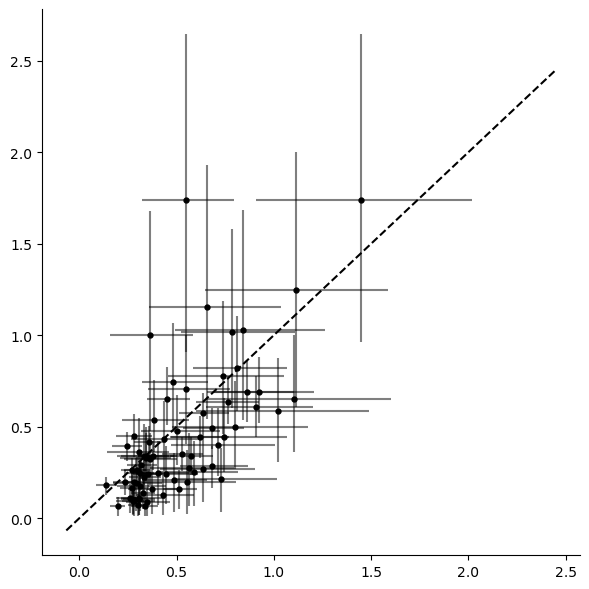

In [209]:
g = sns.FacetGrid(par_stats.unstack(['parameter']).reset_index(), height=6)

g.map_dataframe(plot_scatter_with_errors, color='k', xlabel='n1_evidence_sd', ylabel='n2_evidence_sd')
g.map(plot_identity_line)
# g.set_titles('{col_name}')
# g.set(xlabel='Vertex', ylabel='IPS')
# g.set_xlabels('n1j')
# g.set_ylabels('IPS')

n         r          CI95%     p-val   BF10  \
mask   n_voxels                                                         
NPC12r 1        pearson  73  0.158053  [-0.07, 0.37]  0.181711   0.35   
       100      pearson  73  0.040854  [-0.19, 0.27]  0.731466  0.155   
NPCr   1        pearson  73  0.061389  [-0.17, 0.29]  0.605896  0.167   
       100      pearson  73 -0.152101  [-0.37, 0.08]  0.198928  0.328   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.268401  
       100      pearson  0.063440  
NPCr   1        pearson  0.080946  
       100      pearson  0.251851

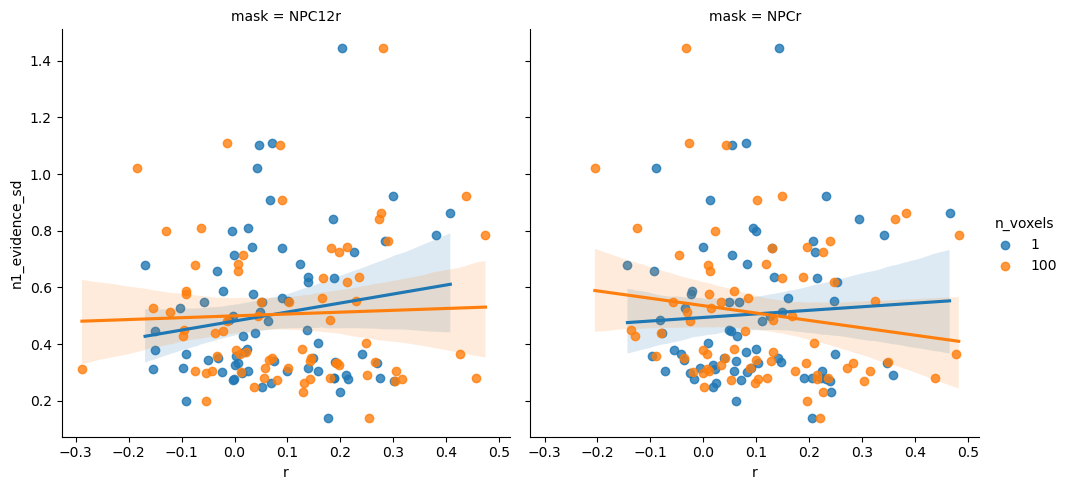

In [210]:
n1_evidence_sd_mean = n1_evidence_sd.groupby(['subject']).mean()
tmp = r2.join(n1_evidence_sd_mean)
tmp['log(n1_evidence_sd)'] = np.log(tmp['n1_evidence_sd'])

sns.lmplot(x='r', y='n1_evidence_sd', data=tmp.reset_index(), col='mask', hue='n_voxels')

pingouin.corr(tmp['r'], tmp['n1_evidence_sd'])

tmp.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['n1_evidence_sd']))

n         r          CI95%     p-val   BF10  \
mask   n_voxels                                                         
NPC12r 1        pearson  73  0.045299  [-0.19, 0.27]  0.703538  0.157   
       100      pearson  73  0.044142  [-0.19, 0.27]  0.710771  0.156   
NPCr   1        pearson  73 -0.006183  [-0.24, 0.22]  0.958594  0.146   
       100      pearson  73 -0.194273  [-0.41, 0.04]  0.099567  0.553   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.066607  
       100      pearson  0.065750  
NPCr   1        pearson  0.050093  
       100      pearson  0.380633

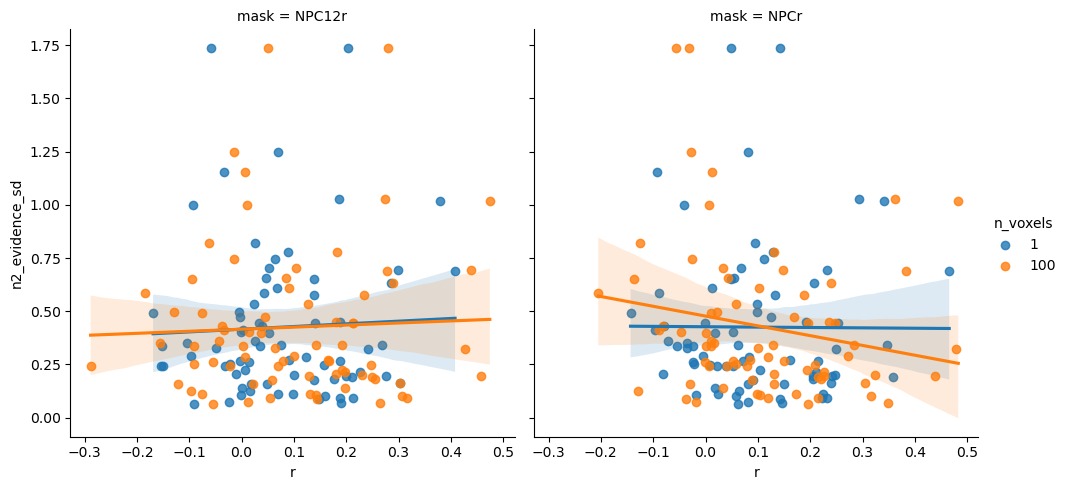

In [211]:
n2_evidence_sd_mean = n2_evidence_sd.groupby(['subject']).mean()
tmp = r2.join(n2_evidence_sd_mean)
tmp['log(n2_evidence_sd)'] = np.log(tmp['n2_evidence_sd'])

sns.lmplot(x='r', y='n2_evidence_sd', data=tmp.reset_index(), col='mask', hue='n_voxels')

pingouin.corr(tmp['r'], tmp['n2_evidence_sd'])

tmp.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['n2_evidence_sd']))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_20977/1452569080.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_sd = pred.groupby(['mask', 'n_voxels', 'subject']).mean()[['sd']]


n         r           CI95%     p-val      BF10  \
mask   n_voxels                                                             
NPC12r 1        pearson  73 -0.521852  [-0.67, -0.33]  0.000002  8617.091   
       100      pearson  73 -0.328651  [-0.52, -0.11]  0.004528     7.592   
NPCr   1        pearson  73 -0.478109  [-0.64, -0.28]  0.000019  1146.974   
       100      pearson  73 -0.254915  [-0.46, -0.03]  0.029518      1.49   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.998203  
       100      pearson  0.819358  
NPCr   1        pearson  0.992261  
       100      pearson  0.592464

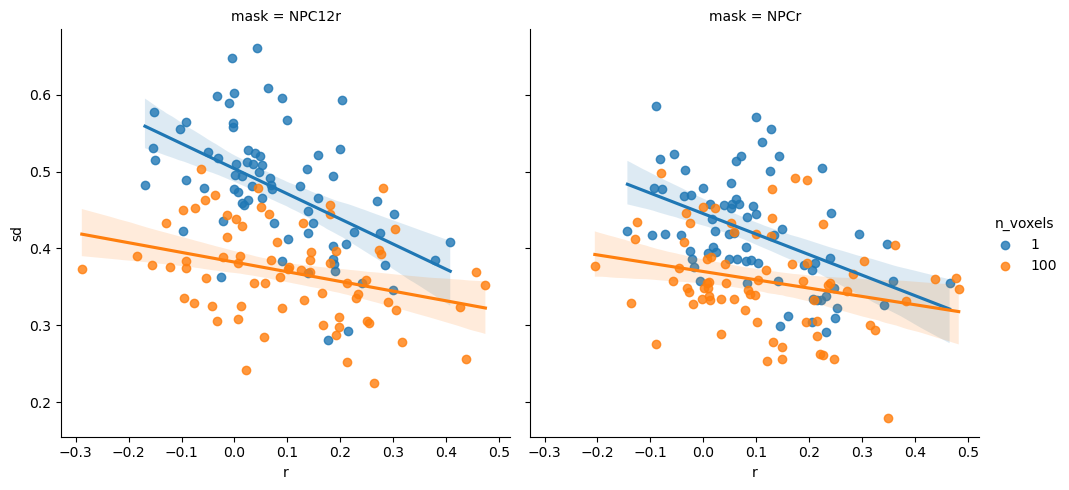

In [212]:
mean_sd = pred.groupby(['mask', 'n_voxels', 'subject']).mean()[['sd']]

mean_sd = mean_sd.join(r2)

sns.lmplot(x='r', y='sd', data=mean_sd.reset_index(), hue='n_voxels', col='mask')

mean_sd.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['sd']))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_20977/1617616272.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_sd = pred.groupby(['mask', 'n_voxels', 'subject']).mean()[['sd']]


n         r          CI95%     p-val   BF10  \
mask   n_voxels                                                         
NPC12r 1        pearson  73  0.223786  [-0.01, 0.43]  0.057009  0.863   
       100      pearson  73  0.152371  [-0.08, 0.37]  0.198124  0.329   
NPCr   1        pearson  73  0.233512    [0.0, 0.44]  0.046781  1.015   
       100      pearson  73  0.061043  [-0.17, 0.29]  0.607933  0.166   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.482399  
       100      pearson  0.252587  
NPCr   1        pearson  0.516853  
       100      pearson  0.080589

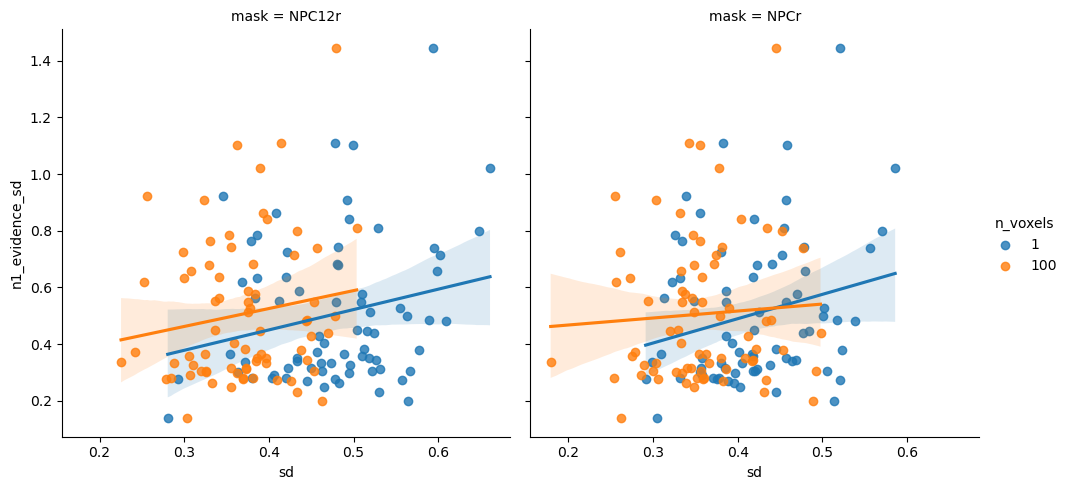

In [213]:
mean_sd = pred.groupby(['mask', 'n_voxels', 'subject']).mean()[['sd']]

mean_sd = mean_sd.join(n1_evidence_sd_mean)

sns.lmplot(x='sd', y='n1_evidence_sd', data=mean_sd.reset_index(), hue='n_voxels', col='mask')

mean_sd.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['sd'], d['n1_evidence_sd']))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_20977/1746772962.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_sd = pred.groupby(['mask', 'n_voxels', 'subject']).mean()[['sd']]


n         r          CI95%     p-val   BF10  \
mask   n_voxels                                                         
NPC12r 1        pearson  73  0.242622   [0.01, 0.45]  0.038621   1.19   
       100      pearson  73  0.295854   [0.07, 0.49]  0.011044  3.465   
NPCr   1        pearson  73  0.204581  [-0.03, 0.42]  0.082531  0.641   
       100      pearson  73  0.171451  [-0.06, 0.39]  0.146959   0.41   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.549168  
       100      pearson  0.728052  
NPCr   1        pearson  0.415458  
       100      pearson  0.307761

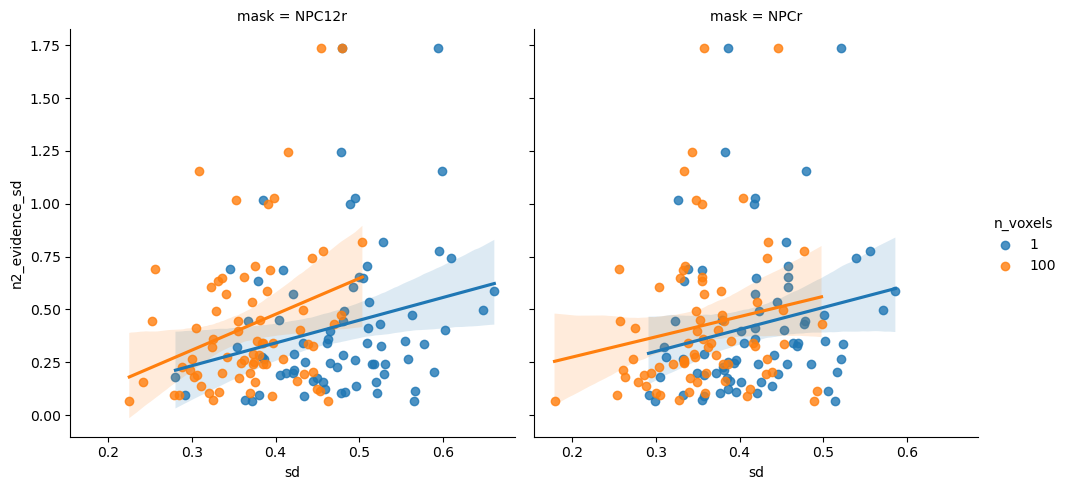

In [214]:
mean_sd = pred.groupby(['mask', 'n_voxels', 'subject']).mean()[['sd']]

mean_sd = mean_sd.join(n2_evidence_sd_mean)

sns.lmplot(x='sd', y='n2_evidence_sd', data=mean_sd.reset_index(), hue='n_voxels', col='mask')

mean_sd.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['sd'], d['n2_evidence_sd']))

In [215]:
sum_evidence_sd = np.sqrt(n1_evidence_sd['n1_evidence_sd']**2 + n2_evidence_sd['n2_evidence_sd']**2)


mean_sum_evidence_sd = sum_evidence_sd.groupby(['subject']).mean().to_frame('mean_evidence_sd')

n         r          CI95%     p-val   BF10  \
mask   n_voxels                                                         
NPC12r 1        pearson  73  0.089395  [-0.14, 0.31]  0.451980  0.193   
       100      pearson  73  0.037496  [-0.19, 0.27]  0.752799  0.153   
NPCr   1        pearson  73  0.018166  [-0.21, 0.25]  0.878759  0.148   
       100      pearson  73 -0.202646  [-0.41, 0.03]  0.085540  0.623   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.117069  
       100      pearson  0.061272  
NPCr   1        pearson  0.052464  
       100      pearson  0.408846

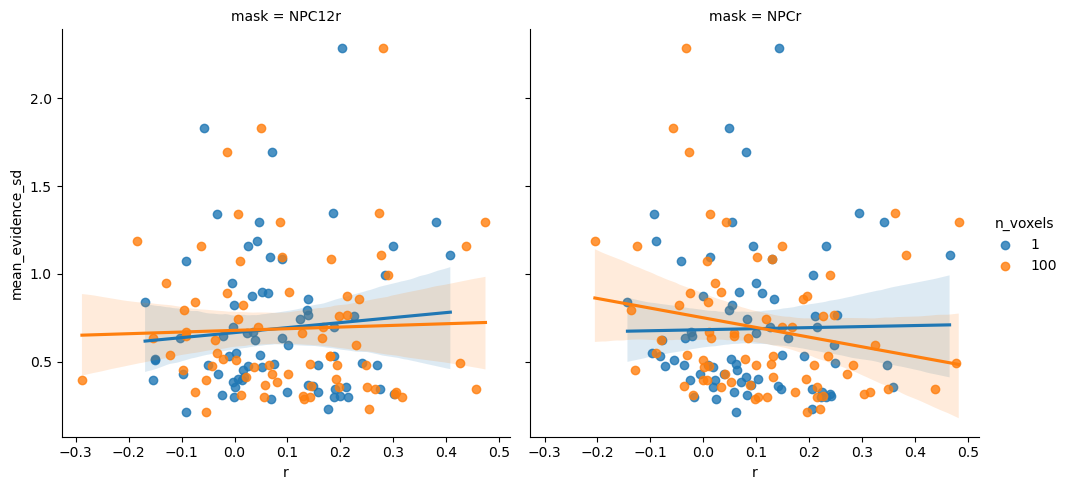

In [216]:
tmp = r2.join(mean_sum_evidence_sd)
tmp['log(mean_evidence_sd)'] = np.log(tmp['mean_evidence_sd'])

sns.lmplot(x='r', y='mean_evidence_sd', data=tmp.reset_index(), col='mask', hue='n_voxels')

pingouin.corr(tmp['r'], tmp['mean_evidence_sd'])

tmp.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['mean_evidence_sd']))

In [217]:
# Only TMS subjects

In [218]:
tms_ids = [int(sub.subject) for sub in get_subjects(all_tms_conditions=True)]

In [219]:
mean_n1_evidence_sd = n1_evidence_sd.loc[slice(None), slice(None), tms_ids].groupby(['subject']).mean()
mean_n2_evidence_sd = n2_evidence_sd.loc[slice(None), slice(None), tms_ids].groupby(['subject']).mean()

In [220]:
r2_tms = r2.loc[tms_ids]

n         r          CI95%     p-val   BF10  \
mask   n_voxels                                                         
NPC12r 1        pearson  35  0.309071  [-0.03, 0.58]  0.070824  1.009   
       100      pearson  35  0.135261  [-0.21, 0.45]  0.438504  0.281   
NPCr   1        pearson  35  0.241752   [-0.1, 0.53]  0.161771  0.539   
       100      pearson  35  0.045699  [-0.29, 0.37]  0.794340  0.217   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.448121  
       100      pearson  0.121500  
NPCr   1        pearson  0.292043  
       100      pearson  0.057444

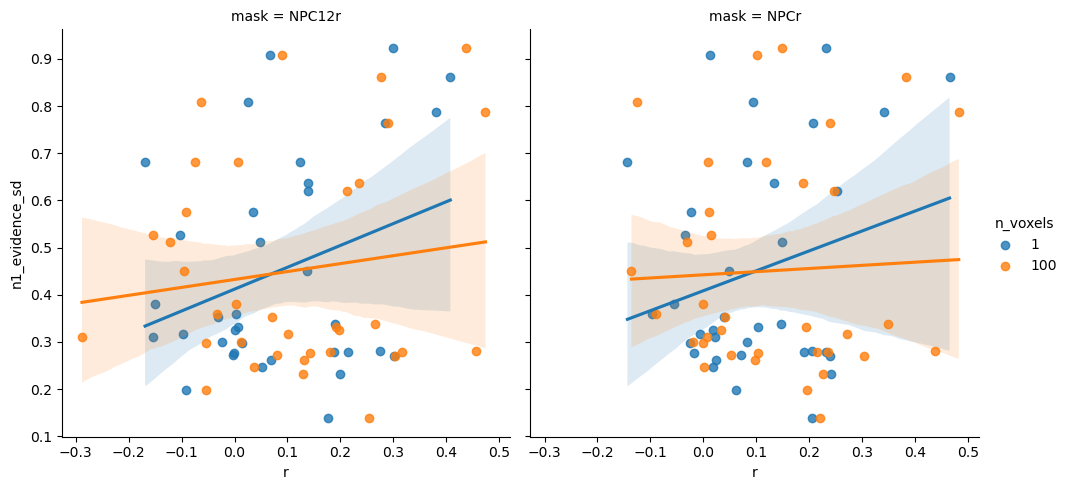

In [221]:
tmp = r2_tms.join(mean_n1_evidence_sd)

tmp['log(n1_evidence_sd)'] = np.log(tmp['n1_evidence_sd'])

sns.lmplot(x='r', y='n1_evidence_sd', data=tmp.reset_index(), col='mask', hue='n_voxels')

pingouin.corr(tmp['r'], tmp['n1_evidence_sd'])

tmp.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['n1_evidence_sd']))

n         r          CI95%     p-val   BF10  \
mask   n_voxels                                                         
NPC12r 1        pearson  35  0.362408   [0.03, 0.62]  0.032395  1.896   
       100      pearson  35  0.176192  [-0.17, 0.48]  0.311320  0.344   
NPCr   1        pearson  35  0.268621  [-0.07, 0.55]  0.118689  0.677   
       100      pearson  35  0.057464  [-0.28, 0.38]  0.742999  0.221   

                            power  
mask   n_voxels                    
NPC12r 1        pearson  0.584755  
       100      pearson  0.174533  
NPCr   1        pearson  0.350812  
       100      pearson  0.062071

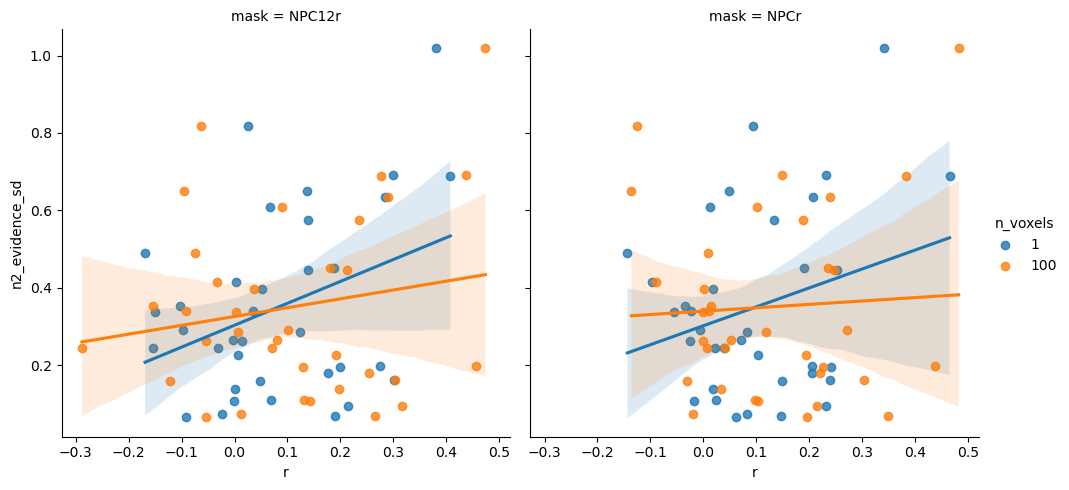

In [222]:
tmp = r2_tms.join(mean_n2_evidence_sd)

tmp['log(n2_evidence_sd)'] = np.log(tmp['n2_evidence_sd'])

sns.lmplot(x='r', y='n2_evidence_sd', data=tmp.reset_index(), col='mask', hue='n_voxels')

pingouin.corr(tmp['r'], tmp['n2_evidence_sd'])

tmp.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['n2_evidence_sd']))

In [223]:
r2.groupby(['mask', 'n_voxels']).mean()

n         r     p-val     power
mask   n_voxels                                    
NPC12r 1         20.0  0.078378  0.500253  0.182604
       100       20.0  0.101307  0.422320  0.224052
NPCr   1         20.0  0.097381  0.470633  0.197447
       100       20.0  0.112769  0.426513  0.226725

In [224]:
r2.unstack(['mask', 'n_voxels'])['r']

mask                                                                 NPC12r  \
n_voxels                                                                1     
subject session stimulation_condition pca    glm     smoothed                 
1       1       baseline              no pca GLMstim not smoothed -0.097427   
2       1       baseline              no pca GLMstim not smoothed  0.051716   
3       1       baseline              no pca GLMstim not smoothed -0.090943   
4       1       baseline              no pca GLMstim not smoothed  0.122986   
5       1       baseline              no pca GLMstim not smoothed  0.275099   
...                                                                     ...   
74      1       baseline              no pca GLMstim not smoothed  0.139490   
75      1       baseline              no pca GLMstim not smoothed  0.042788   
76      1       baseline              no pca GLMstim not smoothed -0.150654   
77      1       baseline              no pca GLMstim not smoothed  0.226564   
78      1       baseline              no pca GLMstim not smoothed  0.015215   

mask                                                                         \
n_voxels                                                                100   
subject session stimulation_condition pca    glm     smoothed                 
1       1       baseline              no pca GLMstim not smoothed  0.100545   
2       1       baseline              no pca GLMstim not smoothed  0.036644   
3       1       baseline              no pca GLMstim not smoothed -0.054829   
4       1       baseline              no pca GLMstim not smoothed  0.006709   
5       1       baseline              no pca GLMstim not smoothed  0.457182   
...                                                                     ...   
74      1       baseline              no pca GLMstim not smoothed  0.213121   
75      1       baseline              no pca GLMstim not smoothed -0.184039   
76      1       baseline              no pca GLMstim not smoothed -0.022280   
77      1       baseline              no pca GLMstim not smoothed  0.197761   
78      1       baseline              no pca GLMstim not smoothed -0.096565   

mask                                                                   NPCr  \
n_voxels                                                                1     
subject session stimulation_condition pca    glm     smoothed                 
1       1       baseline              no pca GLMstim not smoothed -0.005643   
2       1       baseline              no pca GLMstim not smoothed  0.017514   
3       1       baseline              no pca GLMstim not smoothed  0.062787   
4       1       baseline              no pca GLMstim not smoothed  0.082671   
5       1       baseline              no pca GLMstim not smoothed  0.206100   
...                                                                     ...   
74      1       baseline              no pca GLMstim not smoothed  0.253736   
75      1       baseline              no pca GLMstim not smoothed -0.089367   
76      1       baseline              no pca GLMstim not smoothed  0.052115   
77      1       baseline              no pca GLMstim not smoothed  0.211725   
78      1       baseline              no pca GLMstim not smoothed  0.063545   

mask                                                                         
n_voxels                                                                100  
subject session stimulation_condition pca    glm     smoothed                
1       1       baseline              no pca GLMstim not smoothed  0.272080  
2       1       baseline              no pca GLMstim not smoothed  0.000584  
3       1       baseline              no pca GLMstim not smoothed  0.196181  
4       1       baseline              no pca GLMstim not smoothed  0.118849  
5       1       baseline              no pca GLMstim not smoothed  0.437841  
...                                                    